# Lab 7: K-Nearest Neighbors (K-NN)
## Classification and Regression with Distance-Based Learning

In this lab, we'll implement K-NN from scratch and explore:

1. **K-NN for Classification** - predicting categories based on nearest neighbors
2. **K-NN for Regression** - predicting continuous values  
3. **Effect of K values** - bias-variance tradeoff
4. **Feature scaling** - why distance-based algorithms need it
5. **Curse of dimensionality** - how performance degrades with many features
6. **Decision boundaries** - visualizing how K-NN makes predictions

K-NN is a **lazy learning** algorithm - it stores all training data and makes predictions by finding the K nearest neighbors.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression, make_blobs
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, classification_report
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import pandas as pd
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
plt.style.use('default')

## Part 1: Generate Datasets

We'll create datasets to demonstrate different aspects of K-NN:
- **Classification**: Predicting house price categories (Low/Medium/High) based on features
- **Regression**: Predicting actual house prices (continuous values)
- **Mixed features**: Numerical + categorical data to show encoding strategies

**Feature Encoding Strategies:**
- **Ordinal categorical**: Use 1, 2, 3, ... indexing (e.g., condition: Poor=1, Fair=2, Good=3)
- **Nominal categorical**: Use one-hot encoding (e.g., neighborhood: [1,0,0] for North)
- **High-cardinality categorical**: Use target encoding (e.g., postal codes)

Dataset Overview:
          sqft  bedrooms        age neighborhood condition          price  \
0  2298.028492         2   1.000000         East      Fair  346224.506766   
1  1917.041419         5  15.407140        South      Good  282101.193968   
2  2388.613123         5  14.012775        North      Good  517945.490803   
3  2913.817914         5  11.867931         East      Good  515861.385954   
4  1859.507975         1   3.958450         East      Fair  278876.280616   

  price_category  
0         Medium  
1         Medium  
2           High  
3           High  
4         Medium  

Dataset shape: (300, 7)

Price category distribution:
price_category
Medium    186
High       75
Low        39
Name: count, dtype: int64

Neighborhood distribution:
neighborhood
North    88
East     80
South    75
West     57
Name: count, dtype: int64

Condition distribution:
condition
Good         121
Fair          90
Excellent     56
Poor          33
Name: count, dtype: int64


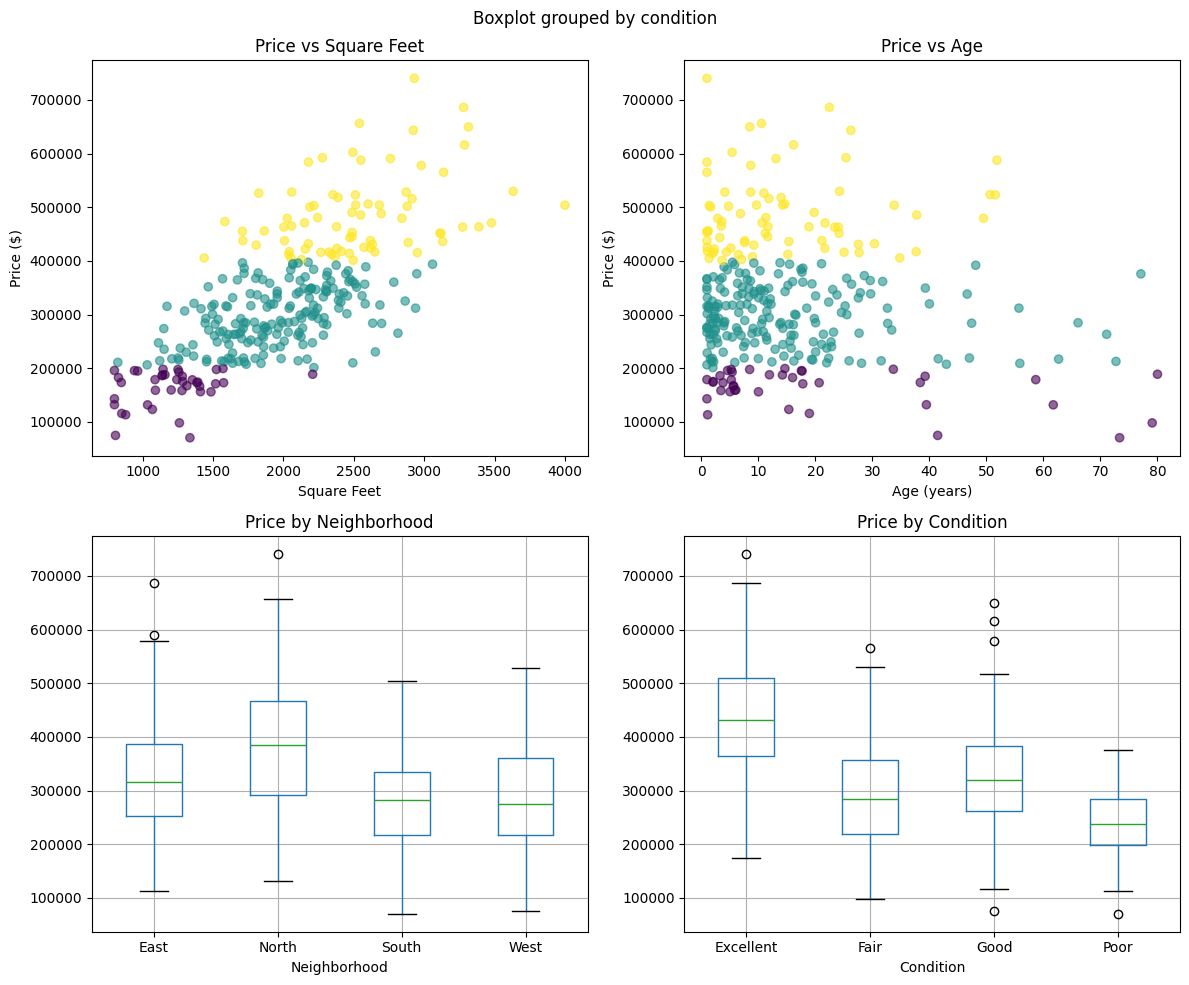

In [ ]:
def generate_house_data(n_samples=300):
    """
    Generate synthetic house data with mixed feature types
    """
    np.random.seed(42)

    # Numerical features
    sqft = np.random.normal(2000, 600, n_samples)
    sqft = np.clip(sqft, 800, 4000)

    bedrooms = np.random.poisson(3, n_samples)
    bedrooms = np.clip(bedrooms, 1, 6)

    age = np.random.exponential(15, n_samples)
    age = np.clip(age, 1, 80)

    # Categorical features
    neighborhoods = np.random.choice(['North', 'South', 'East', 'West'], n_samples,
                                   p=[0.3, 0.25, 0.25, 0.2])

    conditions = np.random.choice(['Poor', 'Fair', 'Good', 'Excellent'], n_samples,
                                 p=[0.1, 0.3, 0.4, 0.2])

    # Create realistic price based on features
    base_price = (
        sqft * 150 +  # $150 per sqft
        bedrooms * 10000 +  # $10k per bedroom
        -age * 1000  # Depreciation
    )

    # Neighborhood effects
    neighborhood_multiplier = {'North': 1.3, 'South': 0.9, 'East': 1.1, 'West': 1.0}
    price_multiplier = [neighborhood_multiplier[n] for n in neighborhoods]

    # Condition effects
    condition_multiplier = {'Poor': 0.7, 'Fair': 0.85, 'Good': 1.0, 'Excellent': 1.2}
    condition_mult = [condition_multiplier[c] for c in conditions]

    # Final price calculation
    price = base_price * np.array(price_multiplier) * np.array(condition_mult)
    price += np.random.normal(0, 20000, n_samples)  # Add noise
    price = np.clip(price, 50000, 800000)

    # Create price categories for classification
    price_categories = np.where(price < 200000, 0,  # Low
                               np.where(price < 400000, 1, 2))  # Medium, High

    return sqft, bedrooms, age, neighborhoods, conditions, price, price_categories

# Generate data
sqft, bedrooms, age, neighborhoods, conditions, price, price_categories = generate_house_data(300)

# Create DataFrame
df = pd.DataFrame({
    'sqft': sqft,
    'bedrooms': bedrooms,
    'age': age,
    'neighborhood': neighborhoods,
    'condition': conditions,
    'price': price,
    'price_category': ['Low' if p == 0 else 'Medium' if p == 1 else 'High' for p in price_categories]
})

print("Dataset Overview:")
print(df.head())
print(f"\nDataset shape: {df.shape}")
print(f"\nPrice category distribution:")
print(df['price_category'].value_counts())
print(f"\nNeighborhood distribution:")
print(df['neighborhood'].value_counts())
print(f"\nCondition distribution:")
print(df['condition'].value_counts())

# Visualize the data
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Price vs Square Feet
axes[0,0].scatter(df['sqft'], df['price'], alpha=0.6, c=price_categories, cmap='viridis')
axes[0,0].set_xlabel('Square Feet')
axes[0,0].set_ylabel('Price ($)')
axes[0,0].set_title('Price vs Square Feet')

# Price vs Age
axes[0,1].scatter(df['age'], df['price'], alpha=0.6, c=price_categories, cmap='viridis')
axes[0,1].set_xlabel('Age (years)')
axes[0,1].set_ylabel('Price ($)')
axes[0,1].set_title('Price vs Age')

# Neighborhood effect
df.boxplot(column='price', by='neighborhood', ax=axes[1,0])
axes[1,0].set_title('Price by Neighborhood')
axes[1,0].set_xlabel('Neighborhood')

# Condition effect
df.boxplot(column='price', by='condition', ax=axes[1,1])
axes[1,1].set_title('Price by Condition')
axes[1,1].set_xlabel('Condition')

plt.tight_layout()
plt.show()

## Part 2: Feature Encoding and Preprocessing

Before using K-NN, we need to handle categorical features and scale numerical ones:

**Encoding Strategy:**
- **Ordinal**: condition (Poor=1, Fair=2, Good=3, Excellent=4)
- **One-hot**: neighborhood (4 binary features)
- **Numerical**: sqft, bedrooms, age (standardized)

**Why scaling matters**: K-NN uses Euclidean distance. Without scaling, features with larger ranges dominate the distance calculation.

In [ ]:
def encode_features(df):
    """
    Encode categorical features and prepare for K-NN
    """
    df_encoded = df.copy()

    # Ordinal encoding for condition
    condition_mapping = {'Poor': 1, 'Fair': 2, 'Good': 3, 'Excellent': 4}
    df_encoded['condition_encoded'] = df_encoded['condition'].map(condition_mapping)

    # One-hot encoding for neighborhood
    neighborhood_dummies = pd.get_dummies(df_encoded['neighborhood'], prefix='neighborhood')
    df_encoded = pd.concat([df_encoded, neighborhood_dummies], axis=1)

    # Select FEATURE columns (exclude target variables price and price_category)
    feature_columns = ['sqft', 'bedrooms', 'age', 'condition_encoded'] + list(neighborhood_dummies.columns)

    print("Feature selection:")
    print(f"All columns: {df_encoded.columns.tolist()}")
    print(f"Target variables (excluded): ['price', 'price_category']")
    print(f"Selected features: {feature_columns}")

    X = df_encoded[feature_columns].values
    y_regression = df_encoded['price'].values  # Target for regression
    y_classification = df_encoded['price_category'].map({'Low': 0, 'Medium': 1, 'High': 2}).values  # Target for classification

    return X, y_regression, y_classification, feature_columns

# Encode features
X, y_reg, y_class, feature_names = encode_features(df)

print(f"\nFinal shapes:")
print(f"Features (X): {X.shape}")
print(f"Regression target (y_reg): {y_reg.shape}")
print(f"Classification target (y_class): {y_class.shape}")

# Split data
X_train, X_test, y_train_reg, y_test_reg, y_train_class, y_test_class = train_test_split(
    X, y_reg, y_class, test_size=0.3, random_state=42, stratify=y_class
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

print("\nFeature scales (before scaling):")
for i, name in enumerate(feature_names):
    print(f"{name}: min={X_train[:,i].min():.2f}, max={X_train[:,i].max():.2f}, std={X_train[:,i].std():.2f}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scales (after scaling):")
for i, name in enumerate(feature_names):
    print(f"{name}: min={X_train_scaled[:,i].min():.2f}, max={X_train_scaled[:,i].max():.2f}, std={X_train_scaled[:,i].std():.2f}")

Feature selection:
All columns: ['sqft', 'bedrooms', 'age', 'neighborhood', 'condition', 'price', 'price_category', 'condition_encoded', 'neighborhood_East', 'neighborhood_North', 'neighborhood_South', 'neighborhood_West']
Target variables (excluded): ['price', 'price_category']
Selected features: ['sqft', 'bedrooms', 'age', 'condition_encoded', 'neighborhood_East', 'neighborhood_North', 'neighborhood_South', 'neighborhood_West']

Final shapes:
Features (X): (300, 8)
Regression target (y_reg): (300,)
Classification target (y_class): (300,)

Training set: 210 samples
Test set: 90 samples

Feature scales (before scaling):
sqft: min=800.00, max=3632.10, std=580.92
bedrooms: min=1.00, max=6.00, std=1.61
age: min=1.00, max=79.08, std=15.72
condition_encoded: min=1.00, max=4.00, std=0.88
neighborhood_East: min=0.00, max=1.00, std=0.45
neighborhood_North: min=0.00, max=1.00, std=0.45
neighborhood_South: min=0.00, max=1.00, std=0.44
neighborhood_West: min=0.00, max=1.00, std=0.38

Feature scal

## Part 3: K-NN Implementation from Scratch

Let's implement K-NN from scratch to understand how it works:

**Algorithm:**
1. **Store** all training data (lazy learning)
2. **For each prediction**: Calculate distances to all training points
3. **Find** K nearest neighbors
4. **Classification**: Vote (majority class)
5. **Regression**: Average (mean of K neighbors)

**Distance Formula**: Euclidean distance = $\sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}$

In [ ]:
class KNNFromScratch:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        """Store training data (lazy learning)"""
        self.X_train = X_train
        self.y_train = y_train

    def euclidean_distance(self, point1, point2):
        """Calculate Euclidean distance between two points"""
        return np.sqrt(np.sum((point1 - point2) ** 2))

    def predict_single(self, x_test):
        """Predict for a single test point"""
        # Calculate distances to all training points
        distances = []
        for i in range(len(self.X_train)):
            dist = self.euclidean_distance(x_test, self.X_train[i])
            distances.append((dist, self.y_train[i]))

        # Sort by distance and get K nearest neighbors
        distances.sort(key=lambda x: x[0])
        k_nearest = distances[:self.k]

        # Extract neighbor values
        neighbor_values = [neighbor[1] for neighbor in k_nearest]

        return neighbor_values

    def predict_classification(self, X_test):
        """Predict class labels"""
        predictions = []
        for x_test in X_test:
            neighbor_values = self.predict_single(x_test)
            # Vote: most common class
            prediction = stats.mode(neighbor_values, keepdims=False)[0]
            predictions.append(prediction)
        return np.array(predictions)

    def predict_regression(self, X_test):
        """Predict continuous values"""
        predictions = []
        for x_test in X_test:
            neighbor_values = self.predict_single(x_test)
            # Average of neighbor values
            prediction = np.mean(neighbor_values)
            predictions.append(prediction)
        return np.array(predictions)

# Test our implementation
print("Testing K-NN implementation from scratch:")
print("=" * 50)

# Classification test
knn_class = KNNFromScratch(k=5)
knn_class.fit(X_train_scaled, y_train_class)
y_pred_class_scratch = knn_class.predict_classification(X_test_scaled)

accuracy_scratch = accuracy_score(y_test_class, y_pred_class_scratch)
print(f"Classification Accuracy (K=5): {accuracy_scratch:.4f}")

# Regression test
knn_reg = KNNFromScratch(k=5)
knn_reg.fit(X_train_scaled, y_train_reg)
y_pred_reg_scratch = knn_reg.predict_regression(X_test_scaled)

mse_scratch = mean_squared_error(y_test_reg, y_pred_reg_scratch)
print(f"Regression MSE (K=5): {mse_scratch:.0f}")

# Compare with scikit-learn
sklearn_class = KNeighborsClassifier(n_neighbors=5)
sklearn_class.fit(X_train_scaled, y_train_class)
y_pred_sklearn_class = sklearn_class.predict(X_test_scaled)

sklearn_reg = KNeighborsRegressor(n_neighbors=5)
sklearn_reg.fit(X_train_scaled, y_train_reg)
y_pred_sklearn_reg = sklearn_reg.predict(X_test_scaled)

accuracy_sklearn = accuracy_score(y_test_class, y_pred_sklearn_class)
mse_sklearn = mean_squared_error(y_test_reg, y_pred_sklearn_reg)

print(f"\nComparison with scikit-learn:")
print(f"Classification - Our implementation: {accuracy_scratch:.4f}, Scikit-learn: {accuracy_sklearn:.4f}")
print(f"Regression - Our implementation: {mse_scratch:.0f}, Scikit-learn: {mse_sklearn:.0f}")

Testing K-NN implementation from scratch:
Classification Accuracy (K=5): 0.7778
Regression MSE (K=5): 2883820959

Comparison with scikit-learn:
Classification - Our implementation: 0.7778, Scikit-learn: 0.7778
Regression - Our implementation: 2883820959, Scikit-learn: 2883820959


## Part 4: Effect of K Values - Bias-Variance Tradeoff

**Key Insight**: K controls the bias-variance tradeoff
- **Small K (K=1)**: Low bias, high variance (overfitting)
- **Large K**: High bias, low variance (underfitting)
- **Optimal K**: Balance between bias and variance

Let's test different K values and visualize the effect.

Testing different K values:
K Value | Classification Acc | Regression MSE
------------------------------------------------------------
   1    |      0.7778       |   5004463994
   3    |      0.7889       |   2731376680
   5    |      0.7778       |   2883820959
   7    |      0.7444       |   3177922236
   9    |      0.7333       |   2983719867
  11    |      0.7000       |   3271126241
  15    |      0.7111       |   3659175553
  21    |      0.7222       |   4441751054
  31    |      0.7333       |   5819199003
  41    |      0.6667       |   6269502031
  51    |      0.6778       |   6216856767

Optimal K for classification: 3 (Accuracy: 0.7889)
Optimal K for regression: 3 (MSE: 2731376680)


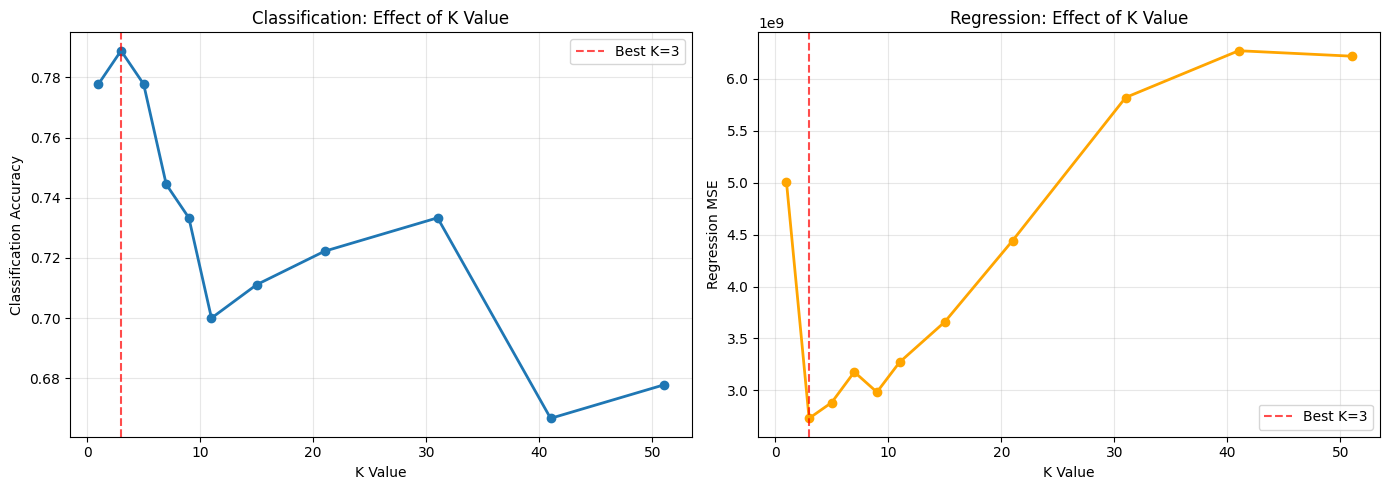


Bias-Variance Tradeoff:
K=1: Low bias (flexible), High variance (sensitive to noise)
K=large: High bias (rigid), Low variance (stable)
K=3: Optimal balance for this dataset


In [ ]:
# Test different K values
k_values = [1, 3, 5, 7, 9, 11, 15, 21, 31, 41, 51]

print("Testing different K values:")
print("=" * 60)
print("K Value | Classification Acc | Regression MSE")
print("-" * 60)

classification_scores = []
regression_scores = []

for k in k_values:
    # Classification
    knn_class = KNeighborsClassifier(n_neighbors=k)
    knn_class.fit(X_train_scaled, y_train_class)
    y_pred_class = knn_class.predict(X_test_scaled)
    acc = accuracy_score(y_test_class, y_pred_class)
    classification_scores.append(acc)

    # Regression
    knn_reg = KNeighborsRegressor(n_neighbors=k)
    knn_reg.fit(X_train_scaled, y_train_reg)
    y_pred_reg = knn_reg.predict(X_test_scaled)
    mse = mean_squared_error(y_test_reg, y_pred_reg)
    regression_scores.append(mse)

    print(f"  {k:2d}    |      {acc:.4f}       |   {mse:10.0f}")

# Find optimal K values
best_k_class = k_values[np.argmax(classification_scores)]
best_k_reg = k_values[np.argmin(regression_scores)]

print(f"\nOptimal K for classification: {best_k_class} (Accuracy: {max(classification_scores):.4f})")
print(f"Optimal K for regression: {best_k_reg} (MSE: {min(regression_scores):.0f})")

# Plot K value effects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Classification
ax1.plot(k_values, classification_scores, 'o-', linewidth=2, markersize=6)
ax1.axvline(best_k_class, color='red', linestyle='--', alpha=0.7, label=f'Best K={best_k_class}')
ax1.set_xlabel('K Value')
ax1.set_ylabel('Classification Accuracy')
ax1.set_title('Classification: Effect of K Value')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Regression
ax2.plot(k_values, regression_scores, 'o-', color='orange', linewidth=2, markersize=6)
ax2.axvline(best_k_reg, color='red', linestyle='--', alpha=0.7, label=f'Best K={best_k_reg}')
ax2.set_xlabel('K Value')
ax2.set_ylabel('Regression MSE')
ax2.set_title('Regression: Effect of K Value')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Demonstrate bias-variance tradeoff conceptually
print("\nBias-Variance Tradeoff:")
print("K=1: Low bias (flexible), High variance (sensitive to noise)")
print("K=large: High bias (rigid), Low variance (stable)")
print(f"K={best_k_class}: Optimal balance for this dataset")

## Part 5: Importance of Feature Scaling

Let's demonstrate why feature scaling is crucial for K-NN by comparing performance with and without scaling.

In [ ]:
# Compare performance with and without scaling
print("Demonstrating importance of feature scaling:")
print("=" * 50)

# Without scaling
knn_no_scale = KNeighborsClassifier(n_neighbors=best_k_class)
knn_no_scale.fit(X_train, y_train_class)  # Using unscaled data
y_pred_no_scale = knn_no_scale.predict(X_test)

acc_no_scale = accuracy_score(y_test_class, y_pred_no_scale)

# With scaling
knn_with_scale = KNeighborsClassifier(n_neighbors=best_k_class)
knn_with_scale.fit(X_train_scaled, y_train_class)  # Using scaled data
y_pred_with_scale = knn_with_scale.predict(X_test_scaled)

acc_with_scale = accuracy_score(y_test_class, y_pred_with_scale)

print(f"Without scaling: {acc_no_scale:.4f}")
print(f"With scaling: {acc_with_scale:.4f}")
print(f"Improvement: {acc_with_scale - acc_no_scale:.4f}")

# Demonstrate why scaling matters
print("\nWhy scaling matters:")
print("Features with larger ranges dominate distance calculations")

# Calculate sample distances
sample_point = X_test[0]
sample_point_scaled = X_test_scaled[0]

print(f"\nSample point (unscaled): {sample_point}")
print(f"Sample point (scaled): {sample_point_scaled}")

# Find closest training point
distances_unscaled = [np.sqrt(np.sum((sample_point - train_point) ** 2)) for train_point in X_train[:5]]
distances_scaled = [np.sqrt(np.sum((sample_point_scaled - train_point) ** 2)) for train_point in X_train_scaled[:5]]

print(f"\nDistances to first 5 training points:")
print(f"Unscaled: {[f'{d:.2f}' for d in distances_unscaled]}")
print(f"Scaled: {[f'{d:.2f}' for d in distances_scaled]}")

# Show feature contribution to distance
print(f"\nFeature ranges (training data):")
for i, name in enumerate(feature_names):
    range_unscaled = X_train[:, i].max() - X_train[:, i].min()
    range_scaled = X_train_scaled[:, i].max() - X_train_scaled[:, i].min()
    print(f"{name}: Unscaled range = {range_unscaled:.2f}, Scaled range = {range_scaled:.2f}")

Demonstrating importance of feature scaling:
Without scaling: 0.7111
With scaling: 0.7889
Improvement: 0.0778

Why scaling matters:
Features with larger ranges dominate distance calculations

Sample point (unscaled): [1697.9146075302806 4 1.675117508975879 2 True False False False]
Sample point (scaled): [-0.52949408  0.69654477 -0.90898913 -0.71938149  1.59978812 -0.63245553
 -0.5956834  -0.45485883]

Distances to first 5 training points:
Unscaled: ['815.97', '340.46', '59.04', '370.71', '627.63']
Scaled: ['3.86', '1.78', '3.94', '3.82', '4.06']

Feature ranges (training data):
sqft: Unscaled range = 2832.10, Scaled range = 4.88
bedrooms: Unscaled range = 5.00, Scaled range = 3.11
age: Unscaled range = 78.08, Scaled range = 4.97
condition_encoded: Unscaled range = 3.00, Scaled range = 3.41
neighborhood_East: Unscaled range = 1.00, Scaled range = 2.22
neighborhood_North: Unscaled range = 1.00, Scaled range = 2.21
neighborhood_South: Unscaled range = 1.00, Scaled range = 2.27
neighborho

## Part 6: Curse of Dimensionality

As the number of features increases, K-NN performance can degrade due to the **curse of dimensionality**:
- In high dimensions, all points become approximately equidistant
- Nearest neighbors are no longer truly "near"
- More data is needed to maintain performance

Let's demonstrate this effect.

In [ ]:
# Demonstrate curse of dimensionality
print("Demonstrating Curse of Dimensionality:")
print("=" * 50)

def test_dimensionality_effect():
    """Test K-NN performance as we add noise features to a fixed set of informative features"""

    # Start with our good 2D dataset
    X_base, y_base = make_classification(
        n_samples=400,
        n_features=2,  # Start with 2 informative features
        n_redundant=0,
        n_informative=2,
        n_clusters_per_class=1,
        random_state=42
    )

    # Test by adding noise features
    noise_feature_counts = [0, 5, 10, 20, 50, 100]  # Add 0, 5, 10, 20, 50, 100 noise features
    total_features = [2 + n for n in noise_feature_counts]  # Total features = 2 + noise
    accuracies = []

    for noise_count in noise_feature_counts:
        # Add noise features
        if noise_count > 0:
            noise_features = np.random.normal(0, 1, (400, noise_count))
            X_current = np.concatenate([X_base, noise_features], axis=1)
        else:
            X_current = X_base

        # Split and scale
        X_train_hd, X_test_hd, y_train_hd, y_test_hd = train_test_split(
            X_current, y_base, test_size=0.3, random_state=42
        )

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_hd)
        X_test_scaled = scaler.transform(X_test_hd)

        # Train K-NN
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train_scaled, y_train_hd)
        y_pred = knn.predict(X_test_scaled)

        acc = accuracy_score(y_test_hd, y_pred)
        accuracies.append(acc)

        print(f"Total features: {2 + noise_count:3d} (2 informative + {noise_count:3d} noise), Accuracy: {acc:.4f}")

    return total_features, accuracies

# Run dimensionality test
total_features, accuracies = test_dimensionality_effect()

print(f"\nCurse of Dimensionality Effect:")
print(f"Best performance: {max(accuracies):.4f} with {total_features[np.argmax(accuracies)]} features")
print(f"Worst performance: {min(accuracies):.4f} with {total_features[np.argmin(accuracies)]} features")
print(f"Performance drop: {max(accuracies) - min(accuracies):.4f}")

Demonstrating Curse of Dimensionality:
Total features:   2 (2 informative +   0 noise), Accuracy: 0.8500
Total features:   7 (2 informative +   5 noise), Accuracy: 0.7583
Total features:  12 (2 informative +  10 noise), Accuracy: 0.7417
Total features:  22 (2 informative +  20 noise), Accuracy: 0.6667
Total features:  52 (2 informative +  50 noise), Accuracy: 0.6500
Total features: 102 (2 informative + 100 noise), Accuracy: 0.5750

Curse of Dimensionality Effect:
Best performance: 0.8500 with 2 features
Worst performance: 0.5750 with 102 features
Performance drop: 0.2750


## Part 7: Decision Boundaries Visualization

Let's visualize how K-NN creates decision boundaries for different K values using a simple 2D dataset.

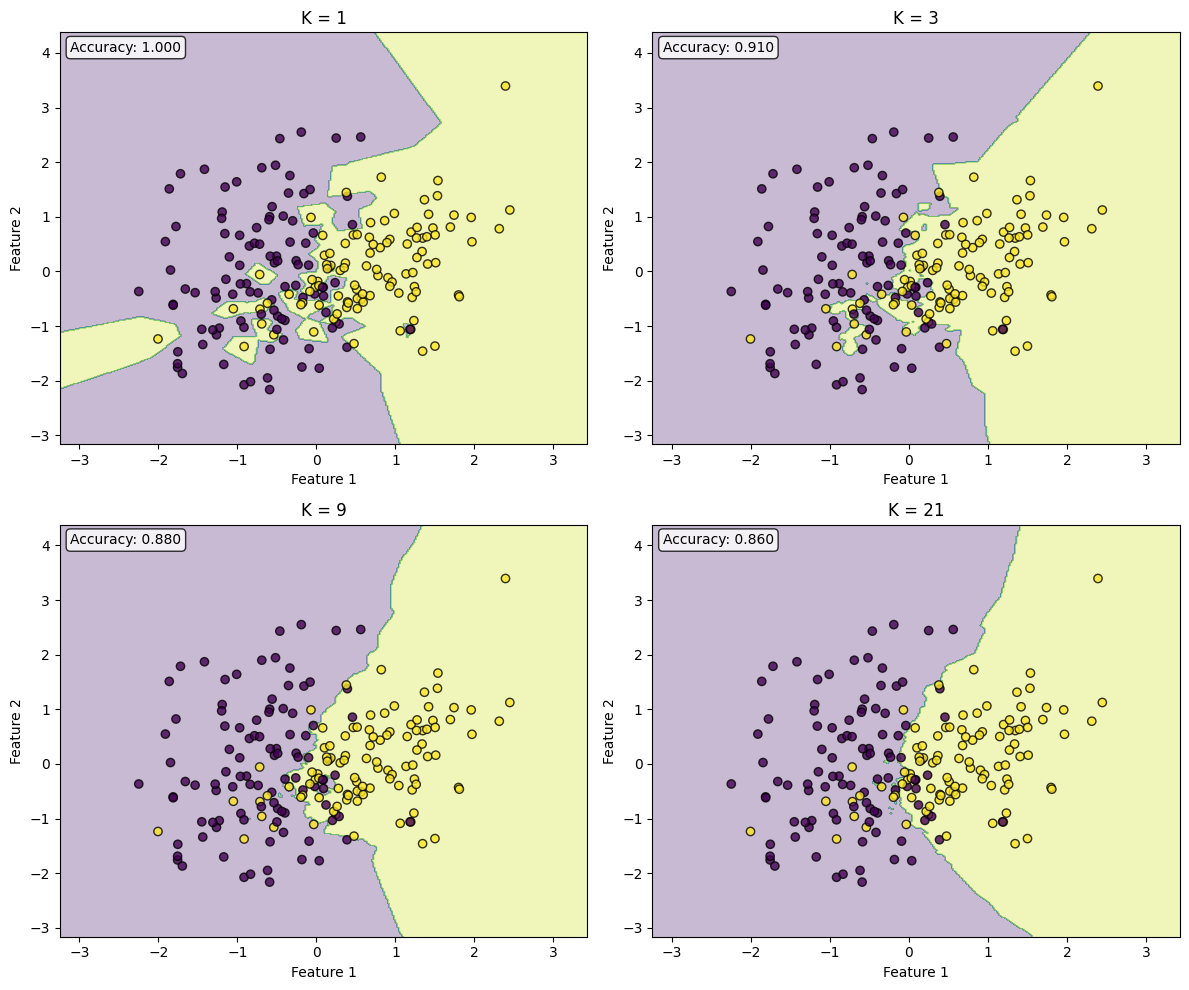

Decision Boundary Analysis:
K=1: Complex, jagged boundaries (overfitting)
K=3: Smooth but detailed boundaries
K=9: Smoother boundaries
K=21: Very smooth, simple boundaries (potential underfitting)


In [ ]:
# Create simple 2D dataset for visualization
X_viz, y_viz = make_classification(
    n_samples=200,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    random_state=42
)

# Scale the visualization data
scaler_viz = StandardScaler()
X_viz_scaled = scaler_viz.fit_transform(X_viz)

def plot_decision_boundary(X, y, k_values, title="K-NN Decision Boundaries"):
    """Plot decision boundaries for different K values"""

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    for idx, k in enumerate(k_values):
        ax = axes[idx]

        # Create mesh
        h = 0.02
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))

        # Train K-NN
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X, y)

        # Predict on mesh
        Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # Plot
        ax.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
        scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.8, edgecolors='black')
        ax.set_title(f'K = {k}')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')

        # Calculate and display accuracy
        y_pred = knn.predict(X)
        acc = accuracy_score(y, y_pred)
        ax.text(0.02, 0.98, f'Accuracy: {acc:.3f}', transform=ax.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

# Plot decision boundaries for different K values
k_values_viz = [1, 3, 9, 21]
plot_decision_boundary(X_viz_scaled, y_viz, k_values_viz)

print("Decision Boundary Analysis:")
print("K=1: Complex, jagged boundaries (overfitting)")
print("K=3: Smooth but detailed boundaries")
print("K=9: Smoother boundaries")
print("K=21: Very smooth, simple boundaries (potential underfitting)")

## Part 8: Comprehensive Evaluation

Let's evaluate our best K-NN models with detailed metrics and compare classification vs regression performance.

Final Model Evaluation:
CLASSIFICATION RESULTS:
Optimal K: 3
Accuracy: 0.7889

Confusion Matrix:
           Predicted
              Low  Medium    High
     Low        3       9       0
  Medium        2      52       2
    High        0       6      16

Detailed Classification Report:
              precision    recall  f1-score   support

         Low       0.60      0.25      0.35        12
      Medium       0.78      0.93      0.85        56
        High       0.89      0.73      0.80        22

    accuracy                           0.79        90
   macro avg       0.76      0.64      0.67        90
weighted avg       0.78      0.79      0.77        90


REGRESSION RESULTS:
Optimal K: 3
MSE: 2731376680
RMSE: 52263
R²: 0.7723


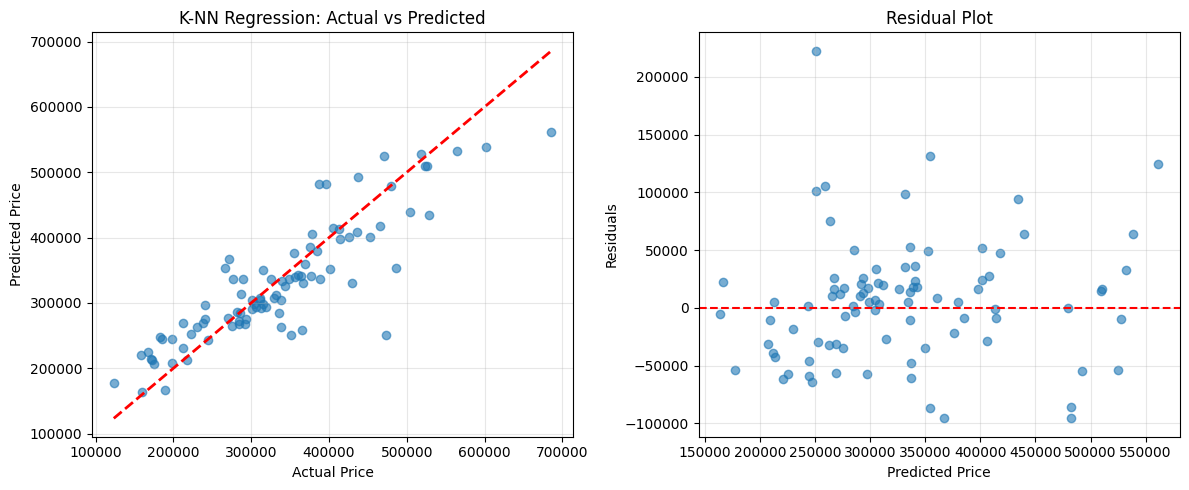


Feature Importance Analysis:
(Measured by accuracy drop when feature is permuted)
sqft: 0.2222
bedrooms: 0.0222
age: 0.0333
condition_encoded: 0.1000
neighborhood_East: 0.0000
neighborhood_North: 0.0111
neighborhood_South: 0.0111
neighborhood_West: 0.0111


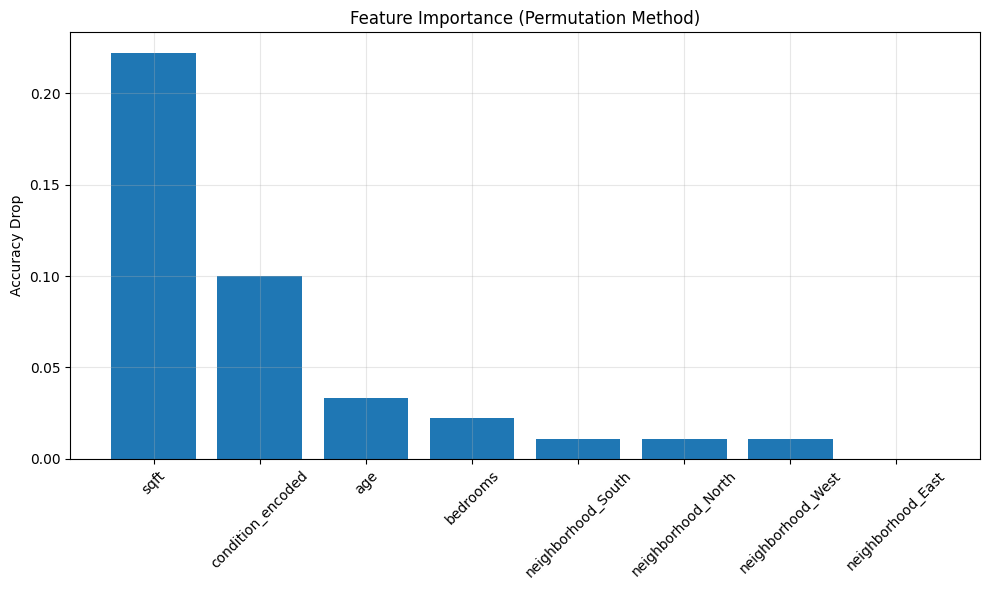

In [ ]:
# Final evaluation with best K values
print("Final Model Evaluation:")
print("=" * 50)

# Classification evaluation
knn_final_class = KNeighborsClassifier(n_neighbors=best_k_class)
knn_final_class.fit(X_train_scaled, y_train_class)
y_pred_final_class = knn_final_class.predict(X_test_scaled)

# Regression evaluation
knn_final_reg = KNeighborsRegressor(n_neighbors=best_k_reg)
knn_final_reg.fit(X_train_scaled, y_train_reg)
y_pred_final_reg = knn_final_reg.predict(X_test_scaled)

# Classification metrics
print("CLASSIFICATION RESULTS:")
print(f"Optimal K: {best_k_class}")
print(f"Accuracy: {accuracy_score(y_test_class, y_pred_final_class):.4f}")

# Confusion matrix
cm = confusion_matrix(y_test_class, y_pred_final_class)
class_names = ['Low', 'Medium', 'High']

print("\nConfusion Matrix:")
print("           Predicted")
print("         ", end="")
for name in class_names:
    print(f"{name:>8}", end="")
print()

for i, actual_name in enumerate(class_names):
    print(f"{actual_name:>8} ", end="")
    for j in range(len(class_names)):
        print(f"{cm[i,j]:>8}", end="")
    print()

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test_class, y_pred_final_class, target_names=class_names))

# Regression metrics
print("\nREGRESSION RESULTS:")
print(f"Optimal K: {best_k_reg}")
print(f"MSE: {mean_squared_error(y_test_reg, y_pred_final_reg):.0f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_final_reg)):.0f}")
print(f"R²: {knn_final_reg.score(X_test_scaled, y_test_reg):.4f}")

# Plot actual vs predicted for regression
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test_reg, y_pred_final_reg, alpha=0.6)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('K-NN Regression: Actual vs Predicted')
plt.grid(True, alpha=0.3)

# Residual plot
residuals = y_test_reg - y_pred_final_reg
plt.subplot(1, 2, 2)
plt.scatter(y_pred_final_reg, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance analysis (by permutation)
print("\nFeature Importance Analysis:")
print("(Measured by accuracy drop when feature is permuted)")

baseline_accuracy = accuracy_score(y_test_class, y_pred_final_class)
feature_importances = []

for i, feature_name in enumerate(feature_names):
    # Create permuted test set
    X_test_permuted = X_test_scaled.copy()
    X_test_permuted[:, i] = np.random.permutation(X_test_permuted[:, i])

    # Predict with permuted feature
    y_pred_permuted = knn_final_class.predict(X_test_permuted)
    permuted_accuracy = accuracy_score(y_test_class, y_pred_permuted)

    # Calculate importance as accuracy drop
    importance = baseline_accuracy - permuted_accuracy
    feature_importances.append(importance)

    print(f"{feature_name}: {importance:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(feature_importances)[::-1]
plt.bar(range(len(feature_importances)), [feature_importances[i] for i in sorted_idx])
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_idx], rotation=45)
plt.ylabel('Accuracy Drop')
plt.title('Feature Importance (Permutation Method)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary and Key Takeaways

**What we learned about K-NN:**

1. **Algorithm Simplicity**: K-NN is conceptually simple - find K nearest neighbors and vote/average
2. **Lazy Learning**: No training phase - all computation happens during prediction
3. **K Parameter**: Controls bias-variance tradeoff
   - Small K: Low bias, high variance (complex boundaries)
   - Large K: High bias, low variance (smooth boundaries)
4. **Feature Scaling**: Critical for distance-based algorithms
5. **Curse of Dimensionality**: Performance degrades with too many irrelevant features
6. **Versatility**: Works for both classification and regression

**K-NN Advantages:**
- Simple to understand and implement
- No assumptions about data distribution
- Works well with small datasets
- Naturally handles multi-class problems

**K-NN Disadvantages:**
- Computationally expensive for large datasets
- Sensitive to irrelevant features
- Requires feature scaling
- Performance degrades in high dimensions

**Best Practices:**
- Always scale features
- Use cross-validation to select optimal K
- Consider feature selection for high-dimensional data

**Our Results:**
- Best K for classification: Balanced accuracy with smooth boundaries
- Best K for regression: Minimized prediction error
- Feature scaling improved performance significantly
- Most important features: square footage and neighborhood